In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras import layers

In [2]:
SEED_VALUE = 42

# To make training deterministic
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Using the Housing Price Prediction dataset

Link: https://www.kaggle.com/datasets/shree1992/housedata

We will predict the house value using the given features

In [3]:
df = pd.read_csv("datasets/housing/data.csv")
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
df.shape

(4600, 18)

In [5]:
# To check if there are any missing values in each column
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [6]:
# Dropping some of the non-numerical features to reduce the dimensions and simplify the dataset
to_drop = ['street', 'statezip', 'date', 'country']
df = df.drop(to_drop, axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond


Some of the yr_renovated values are 0. It may be because it has not been renovated. Checking lowest value beside 0 to know when it was last renovated.

In [7]:
df[df['yr_renovated'] != 0]['yr_renovated'].min()

1912

At least one house was renovated at 1912. 

In [8]:
# How old is the house?
df['house_age'] = [2023 - yr_built for yr_built in df['yr_built']]

# Was the house renovated?
df['was_renovated'] = [1 if yr_renovated != 0 else 0 for yr_renovated in df['yr_renovated']]

# Is the renovation recent?
df['was_renovated_10yrs'] = [1 if (2023 - yr_renovated) <= 10 else 0 for yr_renovated in df['yr_renovated']]
df['was_renovated_30yrs'] = [1 if 10 < (2023 - yr_renovated) <= 30 else 0 for yr_renovated in df['yr_renovated']]

# Dropping yr_renovated column
df.drop(['yr_renovated', 'yr_built'], axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,68,1,0,1
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,102,0,0,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,57,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,60,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,47,1,0,0


In [9]:
df['city'].value_counts()

city
Seattle                1573
Renton                  293
Bellevue                286
Redmond                 235
Issaquah                187
Kirkland                187
Kent                    185
Auburn                  176
Sammamish               175
Federal Way             148
Shoreline               123
Woodinville             115
Maple Valley             96
Mercer Island            86
Burien                   74
Snoqualmie               71
Kenmore                  66
Des Moines               58
North Bend               50
Covington                43
Duvall                   42
Lake Forest Park         36
Bothell                  33
Newcastle                33
SeaTac                   29
Tukwila                  29
Vashon                   29
Enumclaw                 28
Carnation                22
Normandy Park            18
Clyde Hill               11
Medina                   11
Fall City                11
Black Diamond             9
Ravensdale                7
Pacific        

In [10]:
# Creating a function wherein an arbitrary threshold of 50 is set and if the city count does not exceed it, a remap string will return; otherwise, return the name of city.
def remap_location(data: pd.DataFrame, location: str, threshold: int = 50) -> str:
    if len(data[data['city'] == location]) < threshold:
        return 'Uncommon'
    return location

Using Seattle as an example, the function should return the location 'Seattle' since it exceeds the threshold of 50.

In [11]:
print(remap_location(data=df, location='Seattle'))
print(remap_location(data=df, location='Milton'))

Seattle
Uncommon


In [12]:
df['city'] = df['city'].apply(lambda x: remap_location(data=df, location=x))
df.head(25)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,68,1,0,1
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,102,0,0,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,57,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,60,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,47,1,0,0
5,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,Seattle,85,1,0,1
6,335000.0,2.0,2.00,1350,2560,1.0,0,0,3,1350,0,1976,0,Redmond,47,0,0,0
7,482000.0,4.0,2.50,2710,35868,2.0,0,0,3,2710,0,1989,0,Maple Valley,34,0,0,0
8,452500.0,3.0,2.50,2430,88426,1.0,0,0,4,1570,860,1985,0,North Bend,38,0,0,0
9,640000.0,4.0,2.00,1520,6200,1.5,0,0,3,1520,0,1945,2010,Seattle,78,1,0,1


We can see that some values in 'city' were changed to 'Uncommon' since these were cities with less than 50 counts.

# Data Visualization

In [13]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (20,6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

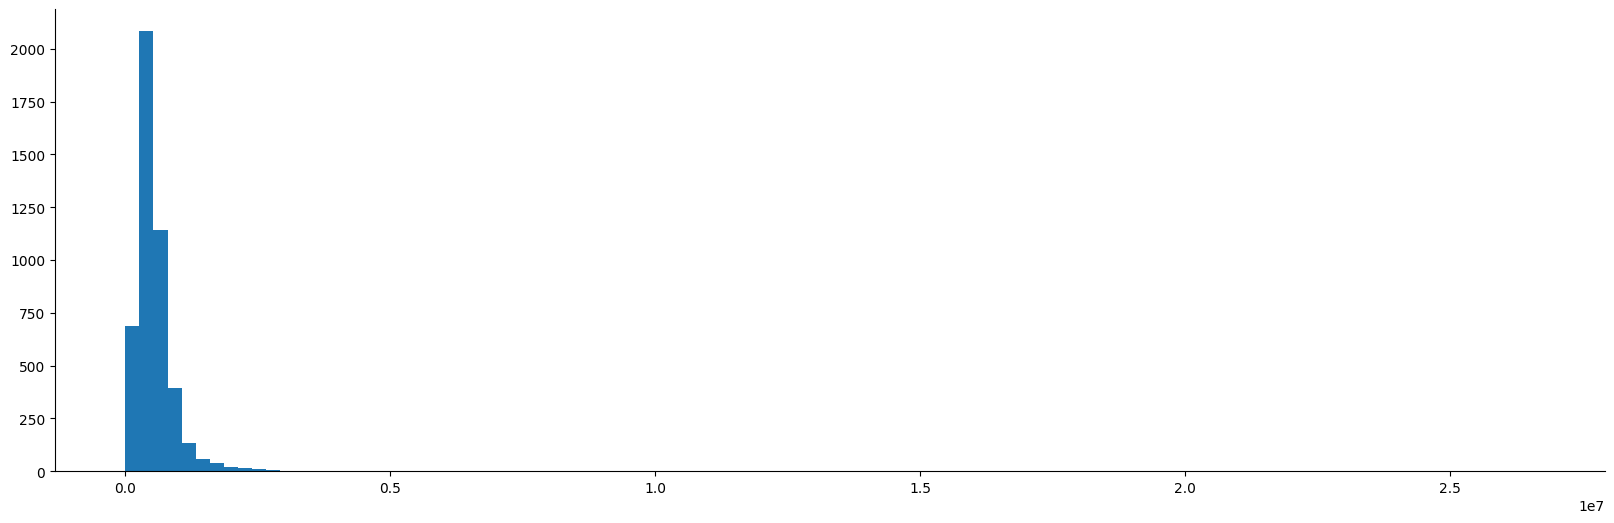

In [14]:
plt.hist(df['price'], bins= 100); # Add a semicolon at the end to prevent printing the values

We can see that there some outliers at the right side of the histogram. The Z-Score can be computed to determine how many standard deviation a value is from the mean. For a normally distributed graph, values that are three times above or below the SD is considered an outlier. However, this example is not normally distributed but we will still apply the Z test.

In [15]:
from scipy import stats

df['price_z'] = np.abs(stats.zscore(df['price'])) # Getting the absolute value since it does not matter if it is + or -
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs,price_z
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,68,1,0,1,0.423864
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,102,0,0,0,3.249598
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,57,0,0,0,0.372424
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,60,0,0,0,0.234071
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,47,1,0,0,0.003482


We can see that the 2nd entry has z-score value of 3.25 meaning it is an outlier. This can be further shown in its price (1st column) having a price that is significantly higher than the other data.

These outliers can be taken out by filtering the z-score values that are less than or equal to 3.

In [16]:
df = df[df['price_z'] <= 3]
df.shape

(4566, 19)

The data was reduced by only 34 (from 4600 to 4566); hence, we can say that the data is still preserved. Plotting the histogram again to see if it changed...

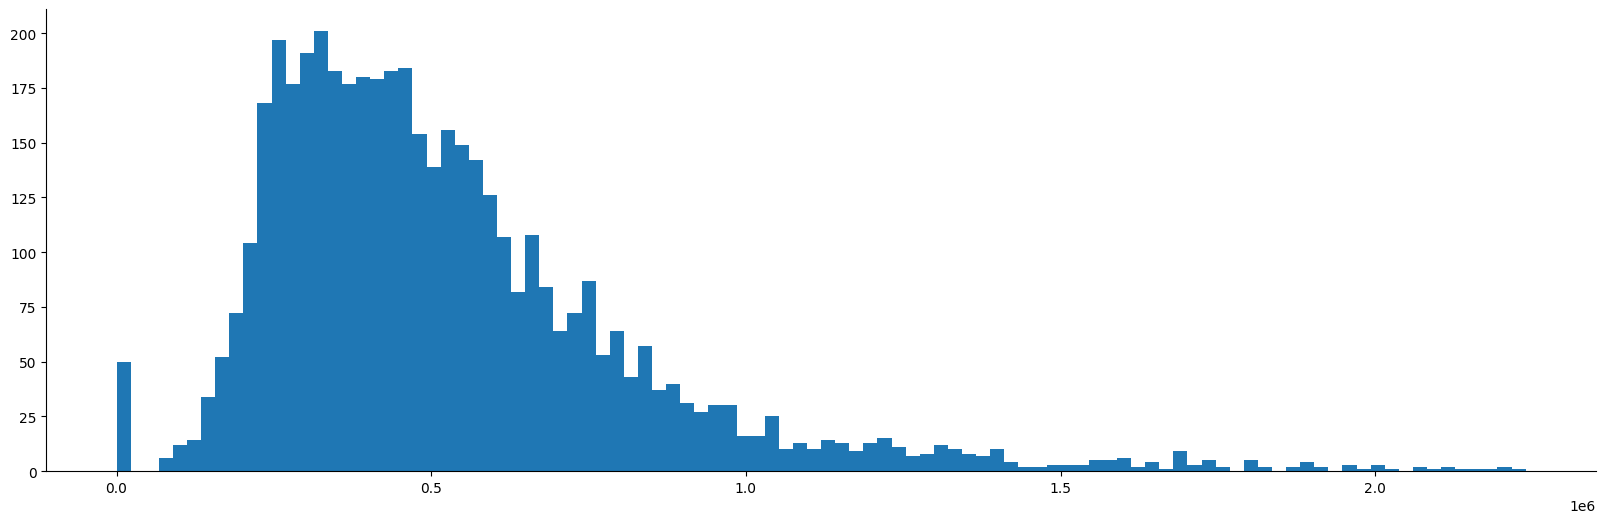

In [17]:
plt.hist(df['price'], bins=100);

We can see that the histogram still has a long tail or skewed (there are still lots of values that are far from the mean) but it is visualized better compared to the first one.

We can also see that there are houses that are priced at $0 which is an anomaly/error. We can remove this to get a better data.

In [18]:
df[df['price'] == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs,price_z
4354,0.0,3.0,1.75,1490,10125,1.0,0,0,4,1490,0,1962,0,Federal Way,61,0,0,0,0.979051
4356,0.0,4.0,2.75,2600,5390,1.0,0,0,4,1300,1300,1960,2001,Seattle,63,1,0,1,0.979051
4357,0.0,6.0,2.75,3200,9200,1.0,0,2,4,1600,1600,1953,1983,Burien,70,1,0,0,0.979051
4358,0.0,5.0,3.50,3480,36615,2.0,0,0,4,2490,990,1983,0,Issaquah,40,0,0,0,0.979051
4361,0.0,5.0,1.50,1500,7112,1.0,0,0,5,760,740,1920,0,Burien,103,0,0,0,0.979051
4362,0.0,4.0,4.00,3680,18804,2.0,0,0,3,3680,0,1990,2009,Sammamish,33,1,0,1,0.979051
4374,0.0,2.0,2.50,2200,188200,1.0,0,3,3,2200,0,2007,0,Uncommon,16,0,0,0,0.979051
4376,0.0,4.0,2.25,2170,10500,1.0,0,2,4,1270,900,1960,2001,Uncommon,63,1,0,1,0.979051
4382,0.0,5.0,4.50,4630,6324,2.0,0,0,3,3210,1420,2006,0,Snoqualmie,17,0,0,0,0.979051
4383,0.0,5.0,4.00,4430,9000,2.0,0,0,3,4430,0,2013,1923,Bellevue,10,1,0,0,0.979051


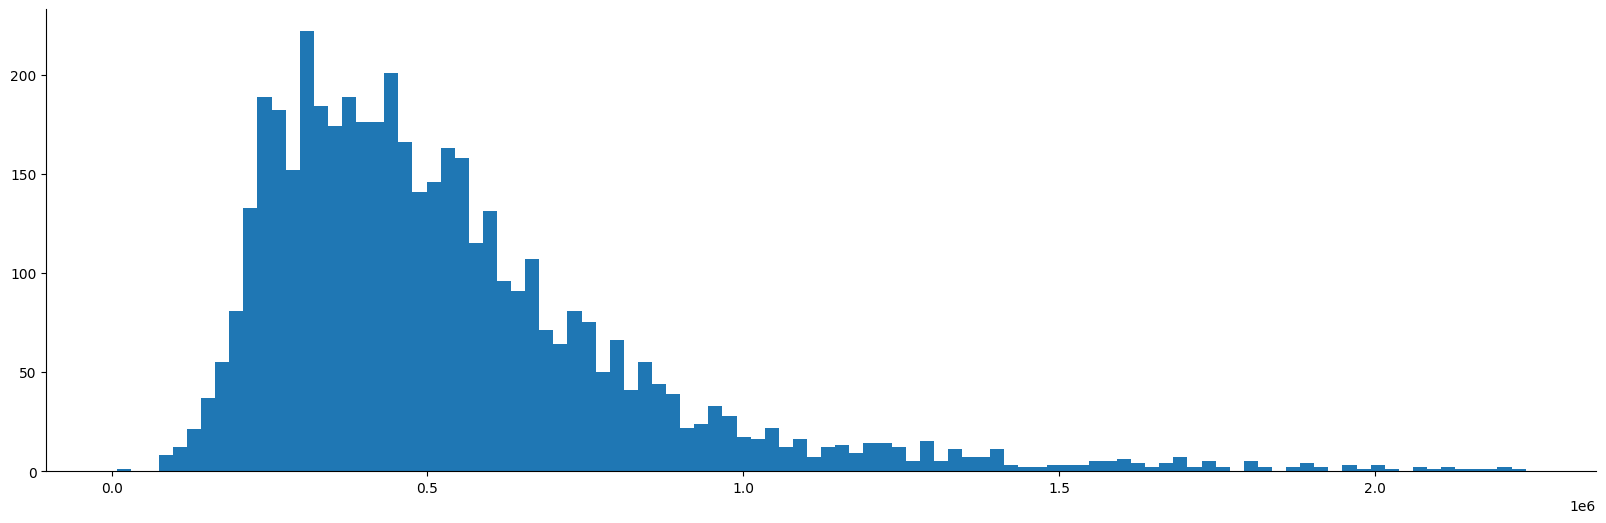

In [19]:
# Filtering these $0 houses out
df = df[df['price'] != 0]

plt.hist(df['price'], bins=100);

Since the z-score has served its purpose (of determining the outliers), we can remove this now since it is insignificant to the machine learning model.

In [20]:
df = df.drop('price_z', axis=1)

In [21]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,68,1,0,1
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,57,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,60,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,47,1,0,0
5,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,Seattle,85,1,0,1


Since machine learning models operate better when the values are scaled, we can do that using sklearn. Also, convert categories to numbers.

We will use make_column_transformer function to process each column.

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [23]:
transformer = make_column_transformer(
    (MinMaxScaler(), ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'house_age']), 
    (OneHotEncoder(handle_unknown='ignore'), ['bedrooms', 'bathrooms', 'floors', 'view', 'condition']), # was_renovated and others were not included since it is already one-hot encoded. Also, handle_unknown was used to handle the unknown values that may be present in the train and test sets
)

Next, separate the features from the target variable. Also, split the train and test sets.

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1) # Separating the features from the target prediction
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((3613, 17), (904, 17))

In [25]:
# Applying the transformation function. Use fit_transform to the training set and transform only to the test set
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

NEVER FIT AND TRANSFORM THE TEST SET

In [26]:
X_train.shape, X_test.shape

((3613, 53), (904, 53))

The features were added due to the one-hot encoding

In [27]:
X_train

<3613x53 sparse matrix of type '<class 'numpy.float64'>'
	with 33918 stored elements in Compressed Sparse Row format>

In [28]:
X_train.toarray()

array([[0.21438849, 0.33897196, 0.21438849, ..., 1.        , 0.        ,
        0.        ],
       [0.26043165, 0.00742988, 0.10503597, ..., 0.        , 0.        ,
        1.        ],
       [0.55251799, 0.02588045, 0.55251799, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.27194245, 0.01478794, 0.27194245, ..., 1.        , 0.        ,
        0.        ],
       [0.56115108, 0.00799192, 0.4028777 , ..., 0.        , 0.        ,
        1.        ],
       [0.21007194, 0.01236491, 0.21007194, ..., 1.        , 0.        ,
        0.        ]])

In [29]:
# Converting the sparse matrix to arrays for the input of the machine learning model
X_train = X_train.toarray()
X_test = X_test.toarray()

# MACHINE LEARNING MODEL

In [30]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

Creating a function for determining the RMSE. MSE should not be used since the output value would be price^2 which is not a unit.

In [31]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) # Notice that Keras was used to compute for this instead of the mean_squared_error function from sklearn as previously used in another project

Setting up a simple neural network model with only 3 hidden (dense) layers

In [32]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1),   
])

# Compiling the model with RMSE as the metric and loss, and using Adam optimizer
model.compile(loss=rmse, optimizer=Adam(), metrics=[rmse])

model.fit(X_train, y_train, epochs=25)

Epoch 1/25
113/113 [==============================] - 3s 5ms/step - loss: 607059.3750 - rmse: 607077.3750
Epoch 2/25
113/113 [==============================] - 0s 4ms/step - loss: 421942.7500 - rmse: 421764.5938
Epoch 3/25
113/113 [==============================] - 0s 3ms/step - loss: 266697.1875 - rmse: 266672.5000
Epoch 4/25
113/113 [==============================] - 0s 3ms/step - loss: 247511.5625 - rmse: 247454.0469
Epoch 5/25
113/113 [==============================] - 0s 3ms/step - loss: 237852.7969 - rmse: 237919.5938
Epoch 6/25
113/113 [==============================] - 0s 3ms/step - loss: 229776.9844 - rmse: 229728.2500
Epoch 7/25
113/113 [==============================] - 0s 3ms/step - loss: 226174.3594 - rmse: 226142.5781
Epoch 8/25
113/113 [==============================] - 0s 4ms/step - loss: 221809.8594 - rmse: 221840.1094
Epoch 9/25
113/113 [==============================] - 0s 4ms/step - loss: 217963.6094 - rmse: 217906.7812
Epoch 10/25
113/113 [=========================

We can see that the RMSE value after 25 epochs is 202,000 meaning that the prediction that this model will make is off by $202,000.

In [33]:
# Making prediction to the test set
predictions = model.predict(X_test)

29/29 [==============================] - 0s 2ms/step


In [34]:
predictions[:5]

array([[ 531716.8 ],
       [ 615985.7 ],
       [1135858.  ],
       [ 254061.22],
       [ 323634.34]], dtype=float32)

In [35]:
# Using the np.ravel to convert it to a 1-D matrix
predictions = np.ravel(predictions)

In [36]:
print(predictions[:5])

[ 531716.8   615985.7  1135858.    254061.22  323634.34]


In [37]:
nn_score = rmse(y_test, predictions).numpy()
print(nn_score)

194561.47853285563


The error is around $195,000 so the model did not overfit. This can be lowered by creating a more complex neural network.

# USING SKLEARN'S LINEAR REGRESSION MODEL

In [38]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'city', 'house_age', 'was_renovated',
       'was_renovated_10yrs', 'was_renovated_30yrs'],
      dtype='object')

In [39]:
from sklearn.linear_model import LinearRegression

skl_linreg = LinearRegression()
skl_linreg.fit(X_train, y_train)

LinearRegression()

In [40]:
skl_preds = skl_linreg.predict(X_test)
skl_preds = np.ravel(skl_preds)
skl_score = rmse(y_test, skl_preds).numpy()
print(skl_score)

6357688356218184.0


In [41]:
from sklearn.metrics import mean_squared_error

skl_linreg_mse = mean_squared_error(y_test, skl_preds)
print(f'MSE: {skl_linreg_mse}')
print(f'RMSE: {np.sqrt(skl_linreg_mse)}')

MSE: 4.0420201234792273e+31
RMSE: 6357688356218184.0


In [42]:
print(np.min(predictions), np.min(skl_preds), np.argmin(skl_preds))

125138.95 -1.9115402668011686e+17 435


So, for some reason, there is one very big outlier when using linear regression of sklearn. Replacing that with the mean value of the predicted values excluding that single outlier.

In [43]:
exclude_arr = np.delete(skl_preds, np.argmin(skl_preds))
mean_arr = np.mean(exclude_arr)
skl_preds[np.argmin(skl_preds)] = mean_arr
skl_preds[435]

534009.550387597

In [44]:
skl_score = rmse(y_test, skl_preds).numpy()
print(f'RMSE: {skl_score}')

RMSE: 190101.33029237442


# USING XGBOOST LINEAR REGRESSION

In [45]:
import xgboost as xgb

In [46]:
xgb_reg = xgb.XGBRegressor(n_estimators=5000,
                          learning_rate=0.01,
                          early_stopping_rounds=100,
                          seed=42)

xgb_reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test,y_test)],
           verbose=100)

[0]	validation_0-rmse:609631.66499	validation_1-rmse:597218.87308
[100]	validation_0-rmse:283505.82118	validation_1-rmse:281623.61931
[200]	validation_0-rmse:185092.76166	validation_1-rmse:204003.42463
[300]	validation_0-rmse:157320.35950	validation_1-rmse:191118.74174
[400]	validation_0-rmse:146740.95405	validation_1-rmse:191168.22976
[426]	validation_0-rmse:144867.55552	validation_1-rmse:191413.16074


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
xgb_score = xgb_reg.evals_result_['validation_1']['rmse'][-1]
xgb_score

191413.1607430579

# SUMMARY

In [48]:
print('RMSE SCORES')
print(f'scikit-learn Linear Regression: {skl_score:0.2f}')
print(f'Neural Network: {nn_score:0.2f}')
print(f'XGBoost: {xgb_score:0.2f}')

RMSE SCORES
scikit-learn Linear Regression: 190101.33
Neural Network: 194561.48
XGBoost: 191413.16


The linear regression model of sklearn achieved the lowest rmse score meaning it is the best model among the three using the given dataset and with minimal hyperparameter tuning/simple NN architecture.

# XGBoost Hyperparameter Tuning

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
params = {'max_depth': [3,6,10],
         'learning_rate': [0.01,0.05,0.1],
         'n_estimators': [100,500,1000],
         'colsample_bytree': [0.3,0.7]}

xgb_tuned_reg = xgb.XGBRegressor(early_stopping_rounds=100, seed=42)
clf = GridSearchCV(estimator=xgb_tuned_reg,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  verbose=1)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test,y_test)], verbose=False)
print("Best Paramters:", clf.best_params_)
print("Lowest RMSE:", np.sqrt(-clf.best_score_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Paramters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Lowest RMSE: 204640.2614167573


In [51]:
xgb_tuned_reg = xgb.XGBRegressor(n_estimators=1000,
                                 learning_rate=0.01,
                                 max_depth=6,
                                 colsample_bytree=0.3,
                                 early_stopping_rounds=100,
                                 seed=42)

xgb_tuned_reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test,y_test)],
           verbose=100)
xgb_tuned_score = xgb_tuned_reg.evals_result_['validation_1']['rmse'][-1]

[0]	validation_0-rmse:609702.05328	validation_1-rmse:597240.77133
[100]	validation_0-rmse:301966.79037	validation_1-rmse:295105.21496
[200]	validation_0-rmse:205550.04922	validation_1-rmse:212426.97316
[300]	validation_0-rmse:175227.43808	validation_1-rmse:195485.52812
[400]	validation_0-rmse:162054.05840	validation_1-rmse:191834.76932
[500]	validation_0-rmse:154039.09607	validation_1-rmse:191160.62544
[600]	validation_0-rmse:147918.51673	validation_1-rmse:190901.39500
[700]	validation_0-rmse:142420.10804	validation_1-rmse:190842.53366
[746]	validation_0-rmse:140524.06675	validation_1-rmse:190832.17265


In [52]:
print('RMSE SCORES')
print(f'scikit-learn Linear Regression: {skl_score:0.2f}')
print(f'Neural Network: {nn_score:0.2f}')
print(f'XGBoost: {xgb_score:0.2f}')
print(f'XGBoost Tuned: {xgb_tuned_score:0.2f}')

RMSE SCORES
scikit-learn Linear Regression: 190101.33
Neural Network: 194561.48
XGBoost: 191413.16
XGBoost Tuned: 190832.17


By performing a hyperparameter tuning, the performance of the XGBoost Regression model improved but sklearn's Linear Regression model was still the best model.

# Checking the Correlation of Features

In [73]:
df_new = df.copy()

In [74]:
to_drop = ['city','yr_built', 'yr_renovated']
df_new = df_new.drop(to_drop, axis=1)
df_new.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,68,1,0,1
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,57,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,60,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,47,1,0,0
5,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,85,1,0,1


In [75]:
corr_matrix = df_new.corr()
corr_matrix['price'].sort_values(ascending=False)

price                  1.000000
sqft_living            0.676764
sqft_above             0.579671
bathrooms              0.515268
view                   0.350364
bedrooms               0.337237
sqft_basement          0.288496
floors                 0.278108
waterfront             0.112198
sqft_lot               0.083797
condition              0.057131
was_renovated_10yrs   -0.001469
house_age             -0.032544
was_renovated         -0.048064
was_renovated_30yrs   -0.060324
Name: price, dtype: float64

In [76]:
df_new.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'house_age', 'was_renovated', 'was_renovated_10yrs',
       'was_renovated_30yrs'],
      dtype='object')

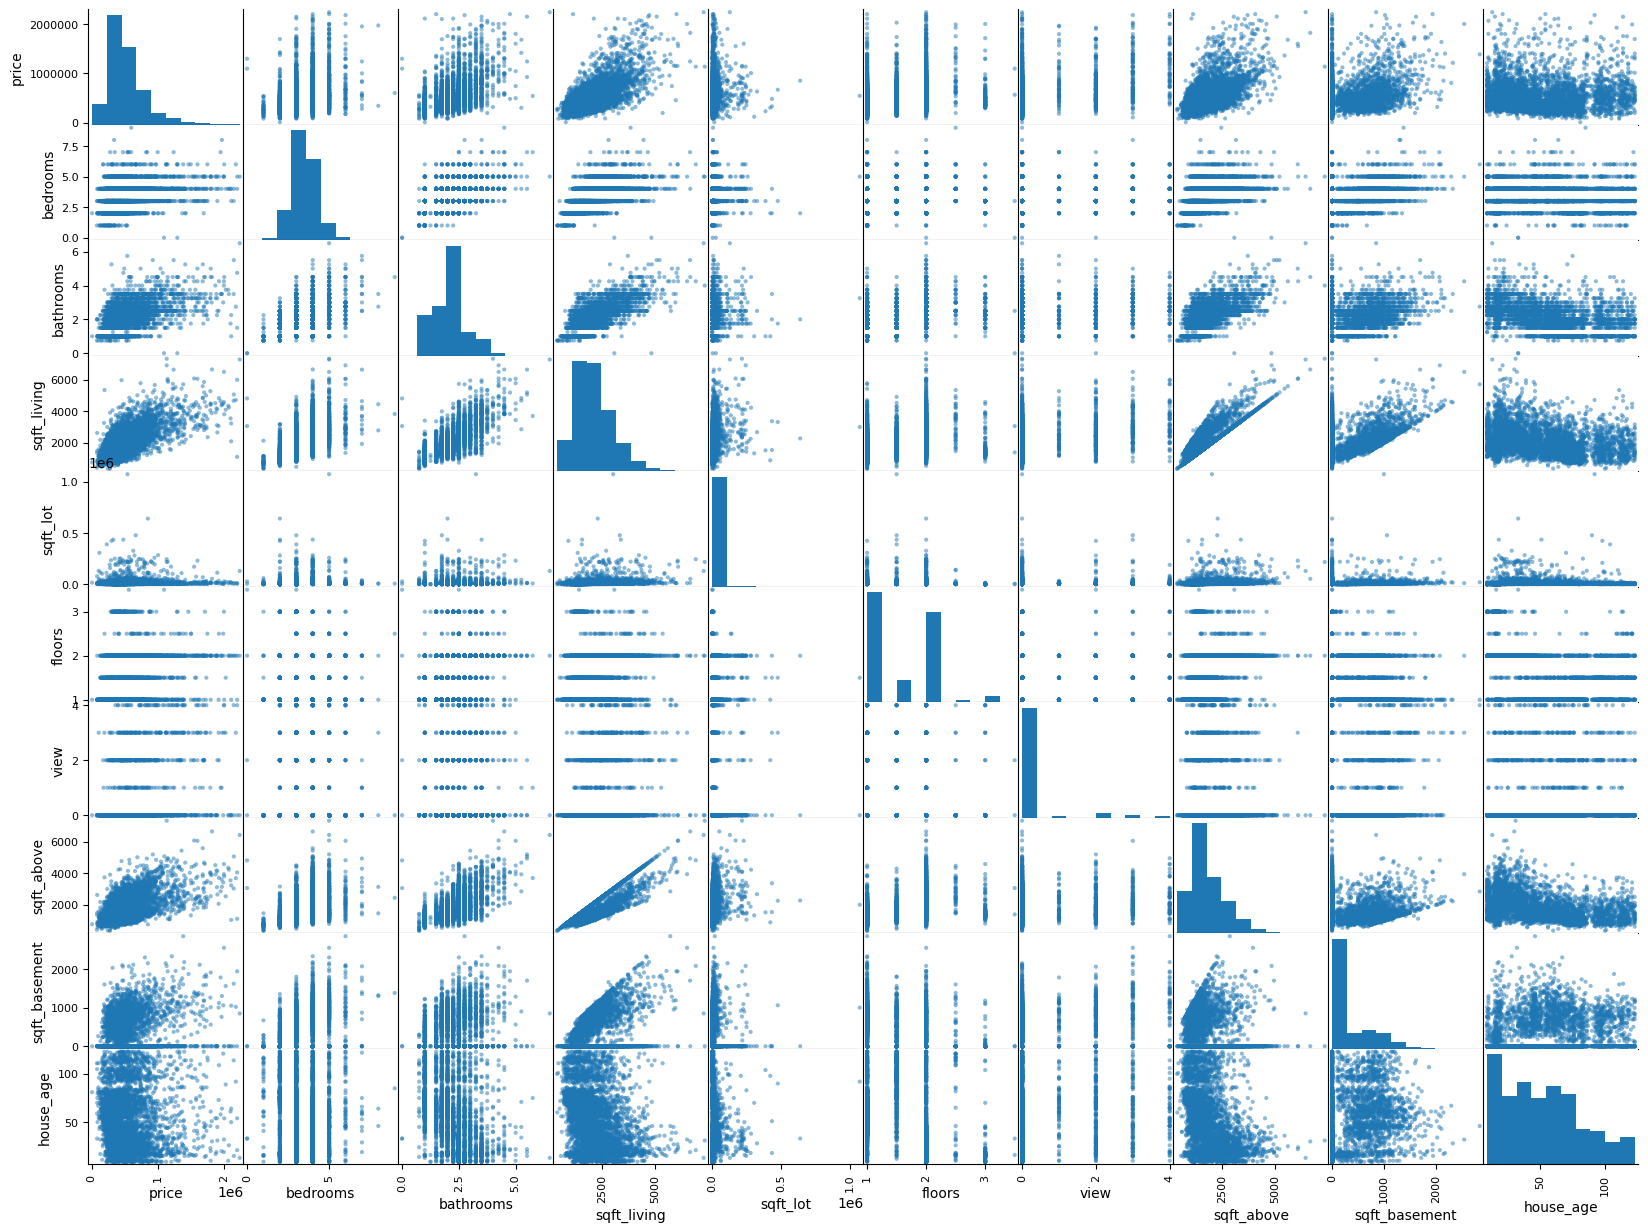

In [88]:
from pandas.plotting import scatter_matrix

attributes = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'sqft_above', 'sqft_basement', 'house_age']
scatter_matrix(df_new[attributes], figsize=(20,15))

plt.show()

As we can see from the correlation matrix, the features sqft_above, bathrooms, and sqft_living are the most, albeit not as obvious, linear relationship in terms of price. This graph further reinforces the correlation values shown before.

In [79]:
df_new.sort_values('sqft_lot', ascending=False)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,house_age,was_renovated,was_renovated_10yrs,was_renovated_30yrs
1078,542500.0,5.0,3.25,3010,1074218,1.5,0,0,5,2010,1000,92,0,0,0
2480,849900.0,2.0,2.00,2280,641203,2.0,0,0,3,2280,0,33,1,0,1
3487,667000.0,3.0,1.75,3320,478288,1.5,0,3,4,2260,1060,90,1,0,0
375,330000.0,2.0,2.00,1550,435600,1.5,0,0,2,1550,0,51,0,0,0
879,480000.0,4.0,3.50,3370,435600,2.0,0,3,3,3370,0,18,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3247,355000.0,2.0,2.25,930,747,2.0,0,0,3,630,300,16,0,0,0
4004,536000.0,2.0,1.50,1130,746,2.0,0,0,3,1030,100,14,0,0,0
1913,742000.0,3.0,3.25,1540,704,3.0,0,0,3,1540,0,12,0,0,0
315,339950.0,2.0,1.00,820,681,3.0,0,0,3,820,0,17,0,0,0


In [80]:
df_new['price'].mean()

532964.3109682212